# Memahami Generative Adversarial Network (GAN)

Generative Adversarial Network (GAN) adalah sebuah *framework* *deep learning* yang terdiri dari dua jaringan saraf yang saling berkompetisi:

1.  **Generator (G):** Bertugas menghasilkan data palsu (dalam kasus ini, gambar) dari *noise* acak. Tujuannya adalah membuat data yang terlihat realistis.
2.  **Discriminator (D):** Bertugas membedakan antara data asli (dari dataset) dan data palsu yang dihasilkan oleh Generator.

Kedua jaringan dilatih dalam sebuah "permainan" adversarial: Generator berusaha menipu Discriminator, dan Discriminator berusaha menangkap Generator. Proses ini memungkinkan Generator belajar menghasilkan data yang semakin meyakinkan.

In [2]:
%%writefile models.py
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(512, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.Sigmoid(),
            nn.Flatten()
        )
    
    def forward(self, x):
        x = self.backbone(x)
        return x


class Generator(nn.Module):
    def __init__(self, embedding_dim):
        super(Generator, self).__init__()
        self.embedding_dim = embedding_dim

        self.backbone = nn.Sequential(
            nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=512, kernel_size=4, stride=1, padding=0, output_padding=0, bias=False), 
            nn.BatchNorm2d(512, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), 
            nn.BatchNorm2d(256, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), 
            nn.BatchNorm2d(128, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), 
            nn.BatchNorm2d(64, momentum=0.1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), 
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(-1, self.embedding_dim, 1, 1)
        x = self.backbone(x)
        return x

Writing models.py


## 1. Definisi Arsitektur Model (models.py)

Bagian ini mendefinisikan dua komponen utama dari GAN: Discriminator dan Generator. Kedua model ini diimplementasikan menggunakan arsitektur Deep Convolutional GAN (DCGAN).

### Discriminator (D)

Discriminator bertugas membedakan antara gambar asli dari dataset dan gambar palsu yang dihasilkan oleh Generator.

* **Arsitektur:** Menggunakan lapisan `Conv2d` (Convolutional Layer) untuk memproses gambar, `BatchNorm2d` untuk menstabilkan pelatihan, dan `LeakyReLU` sebagai fungsi aktivasi.
* **Lapisan Akhir:** Menggunakan `nn.Conv2d` terakhir dengan `nn.Sigmoid()` untuk menghasilkan *output* tunggal (probabilitas) bahwa gambar tersebut asli (mendekati 1) atau palsu (mendekati 0).
* **Dropout:** Digunakan untuk mencegah *overfitting* pada Discriminator.

### Generator (G)

Generator bertugas menghasilkan gambar baru dari *noise* acak.

* **Arsitektur:** Menggunakan lapisan `nn.ConvTranspose2d` (lapisan dekonvolusional) untuk *upsampling* data. Ini efektif untuk mengubah vektor *noise* menjadi gambar.
* **Proses:** Input `noise` (vektor laten `embedding_dim`) diubah menjadi bentuk 4D (`-1, embedding_dim, 1, 1`) dan diperluas melalui lapisan *deconv* yang semakin besar.
* **Lapisan Akhir:** Menggunakan `nn.Tanh()` di lapisan *output* untuk menormalisasi gambar hasil *generate* ke rentang [-1, 1].

In [3]:
%%writefile utils.py
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

def save_generated_images(epoch, generator, latent_dim, examples=10, device='cpu'):
    generator.eval()
    z = torch.randn(examples, latent_dim).to(device)

    generated_images = generator(z).detach().cpu()

    generated_images = generated_images * 0.5 + 0.5
    
    output_dir = "output/generated_images"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig, axes = plt.subplots(1, examples, figsize=(15, 2))
    for i in range(examples):
        axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.savefig(f"{output_dir}/generated_epoch_{epoch}.png")
    plt.close()

def loss_d(device, real_pred, fake_pred):
    real_labels = torch.ones_like(real_pred)
    fake_labels = torch.zeros_like(fake_pred)

    noisy_real_labels = real_labels - (0.1 * torch.rand(real_pred.shape, device=device))
    noisy_fake_labels = fake_labels + (0.1 * torch.rand(fake_pred.shape, device=device))

    loss_real_labels = F.binary_cross_entropy(real_pred, noisy_real_labels)
    loss_fake_labels = F.binary_cross_entropy(fake_pred, noisy_fake_labels)

    return (loss_real_labels + loss_fake_labels)

def loss_g(device, fake_pred):
    return F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred).to(device))

Writing utils.py


## 2. Fungsi Pembantu dan Loss (utils.py)

Bagian ini berisi fungsi-fungsi penting yang mendukung proses pelatihan GAN dan visualisasi hasilnya.

### Fungsi `save_generated_images`

Fungsi ini digunakan untuk memvisualisasikan kemajuan Generator selama pelatihan.

* Fungsi ini menerima output dari Generator, mengubahnya dari rentang [-1, 1] menjadi [0, 1], dan menyusun gambar-gambar tersebut.
* Gambar disimpan ke folder `output/generated_images/` dalam format PNG, memungkinkan kita melihat bagaimana kualitas gambar meningkat seiring berjalannya *epoch*.

### Fungsi `loss_d` (Discriminator Loss)

Fungsi ini menghitung *loss* untuk Discriminator. Tujuannya adalah menghukum Discriminator jika ia salah mengklasifikasikan gambar asli atau palsu.

* Fungsi ini menggunakan **Binary Cross-Entropy (BCE) Loss**.
* Fungsi ini juga mengimplementasikan **label smoothing** (menambahkan sedikit *noise* pada label asli dan palsu) untuk meningkatkan stabilitas pelatihan GAN.

### Fungsi `loss_g` (Generator Loss)

Fungsi ini menghitung *loss* untuk Generator. Tujuannya adalah mengukur seberapa baik Generator mampu menipu Discriminator.

* Fungsi ini juga menggunakan BCE Loss.
* Generator dianggap berhasil jika Discriminator mengklasifikasikan gambar palsu sebagai gambar asli (target 1).

In [4]:
%%writefile dataset.py
import torch
from torch.utils.data import Dataset
from PIL import Image

class DatasetImages(Dataset):
    def __init__(self, paths_images, transform=None):
        self.paths_images = paths_images
        self.transform = transform

    def __len__(self):
        return len(self.paths_images)

    def __getitem__(self, idx):
        img_path = self.paths_images[idx]
        image = Image.open(img_path).convert('L') 

        if self.transform:
            image = self.transform(image)
        
        return image

Writing dataset.py


## 3. Persiapan Dataset (dataset.py)

Bagian ini mendefinisikan cara data gambar dimuat dan diproses untuk pelatihan GAN. Kode ini menggunakan PyTorch `Dataset` untuk menangani *input* data.

### Kelas `DatasetImages`

Kelas ini berfungsi untuk:

1.  **Memuat Gambar:** Menggunakan pustaka PIL (Python Imaging Library) untuk membuka gambar dari jalur yang diberikan (`__getitem__`).
2.  **Konversi Grayscale:** Gambar dikonversi ke *grayscale* (`.convert('L')`) karena model GAN yang digunakan beroperasi pada citra satu *channel*.
3.  **Transformasi:** Jika ada transformasi yang ditentukan (`transform=transforms.Compose(...)`), transformasi tersebut diterapkan pada gambar (misalnya, *resize* dan *normalisasi*).
4.  **Menghitung Ukuran Dataset:** Fungsi `__len__` mengembalikan jumlah total gambar yang tersedia.

In [5]:

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
import matplotlib.pyplot as plt
import types 

from utils import loss_d, loss_g, save_generated_images
from dataset import DatasetImages
from models import Discriminator, Generator


def _init_(args):
    if not os.path.exists('output'):
        os.makedirs('output')
    if not os.path.exists('output/'+args.exp_name):
        os.makedirs('output/'+args.exp_name)
    if not os.path.exists('output/'+args.exp_name+'/'+'models'):
        os.makedirs('output/'+args.exp_name+'/'+'models')


def main(args):
    path_to_images = args.dataset_path
    path_to_dir = args.output_path

    coeff_train = 1.0 
    batch_size = args.batch_size
    embedding_dim = args.embedding_dim
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f"Device: {device}")

    Path(f"{path_to_dir}/weights_dcgan").mkdir(exist_ok=True)
    Path(f"{path_to_dir}/generated_images").mkdir(exist_ok=True)

    lr_g = args.lr_g
    lr_d = args.lr_d
    epochs = args.epochs

    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    paths_images = list(Path(path_to_images).iterdir())
    random.shuffle(paths_images)
    paths_train = paths_images[:int(len(paths_images) * coeff_train)]

    data_train = DatasetImages(paths_train, transform=transform)
    train_loader = DataLoader(data_train, shuffle=True, batch_size=batch_size)

    generator = Generator(embedding_dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))


    print("Memulai pelatihan...")
    for epoch in range(epochs):

        total = 0
        total_loss_g = 0
        total_loss_d = 0

        with tqdm(train_loader, desc=f"Epoch {epoch}", leave=False) as pbar:

            for batch in pbar:
                real_images = batch.to(device)
                batch_size = len(real_images)
                random_latent_vectors = torch.randn(batch_size, embedding_dim).to(device)

                # Training Discriminator (D)
                for _ in range(5):
                    optimizer_d.zero_grad()
                    with torch.no_grad():
                        generated_images = generator(random_latent_vectors).to(device)

                    real_preds = discriminator(real_images)
                    fake_preds = discriminator(generated_images)

                    loss_discriminator = loss_d(device, real_preds, fake_preds)
                    loss_discriminator.backward()
                    optimizer_d.step()

                # Training Generator (G)
                optimizer_g.zero_grad()
                random_latent_vectors = torch.randn(batch_size, embedding_dim).to(device)
                generated_images = generator(random_latent_vectors)
                
                fake_preds = discriminator(generated_images)
                loss_generator = loss_g(device, fake_preds)

                loss_generator.backward()
                optimizer_g.step()

                total_loss_g += loss_generator.item() * batch_size
                total_loss_d += loss_discriminator.item() * batch_size
                total += batch_size

                pbar.set_postfix({
                    "Loss d" : f"{loss_discriminator.item():.4f}",
                    "Loss g" : f"{loss_generator.item():.4f}",
                })

        loss_generator_result = total_loss_g / total
        loss_discriminator_result = total_loss_d / total
        
        save_generated_images(epoch, generator, embedding_dim, examples=10, device=device)
        
        tqdm.write(f"Epoch: {epoch}, loss_g: {loss_generator_result:.4f}, loss_d: {loss_discriminator_result:.4f}")

    torch.save(generator.state_dict(), path_to_dir + '/weights_dcgan/generator.pt')
    torch.save(discriminator.state_dict(), path_to_dir + '/weights_dcgan/discriminator.pt')


args = types.SimpleNamespace()
args.exp_name = 'lego_dcgan'
args.dataset_path = '/kaggle/input/lego-brick-images/dataset' 
args.output_path = 'output'
args.lr_d = 0.0002
args.lr_g = 0.0001
args.epochs = 50 
args.batch_size = 64
args.embedding_dim = 100 
args.eval = False
args.model_path = 'output/weights_dcgan/generator.pt'

_init_(args)

if not args.eval:
    main(args)

Device: cuda
Memulai pelatihan...


Epoch: 0, loss_g: 2.9965, loss_d: 0.3997


Epoch: 1, loss_g: 2.9974, loss_d: 0.4179


Epoch: 2, loss_g: 2.9121, loss_d: 0.4335


Epoch: 3, loss_g: 2.9068, loss_d: 0.4246


Epoch: 4, loss_g: 2.8693, loss_d: 0.4249


Epoch: 5, loss_g: 2.9184, loss_d: 0.4191


Epoch: 6, loss_g: 2.8577, loss_d: 0.4226


Epoch: 7, loss_g: 2.9414, loss_d: 0.4190


Epoch: 8, loss_g: 2.9479, loss_d: 0.4190


Epoch: 9, loss_g: 2.9254, loss_d: 0.4198


Epoch: 10, loss_g: 2.9548, loss_d: 0.4185


Epoch: 11, loss_g: 2.9694, loss_d: 0.4168


Epoch: 12, loss_g: 2.9921, loss_d: 0.4164


Epoch: 13, loss_g: 2.9583, loss_d: 0.4167


Epoch: 14, loss_g: 2.9592, loss_d: 0.4172


Epoch: 15, loss_g: 2.9323, loss_d: 0.4155


Epoch: 16, loss_g: 2.9433, loss_d: 0.4157


Epoch: 17, loss_g: 2.9199, loss_d: 0.4150


Epoch: 18, loss_g: 2.9495, loss_d: 0.4135


Epoch: 19, loss_g: 2.9284, loss_d: 0.4154


Epoch: 20, loss_g: 2.9673, loss_d: 0.4168


Epoch: 21, loss_g: 2.9161, loss_d: 0.4156


Epoch: 22, loss_g: 2.9351, loss_d: 0.4151


Epoch: 23, loss_g: 2.9623, loss_d: 0.4112


Epoch: 24, loss_g: 2.9586, loss_d: 0.4130


Epoch: 25, loss_g: 2.8837, loss_d: 0.4112


Epoch: 26, loss_g: 2.8881, loss_d: 0.4113


Epoch: 27, loss_g: 2.9258, loss_d: 0.4140


Epoch: 28, loss_g: 2.9083, loss_d: 0.4108


Epoch: 29, loss_g: 2.9091, loss_d: 0.4141


Epoch: 30, loss_g: 2.9201, loss_d: 0.4093


Epoch: 31, loss_g: 2.8499, loss_d: 0.4143


Epoch: 32, loss_g: 2.9083, loss_d: 0.4081


Epoch: 33, loss_g: 2.9187, loss_d: 0.4112


Epoch: 34, loss_g: 2.9214, loss_d: 0.4092


Epoch: 36, loss_g: 2.9141, loss_d: 0.4084


Epoch: 37, loss_g: 2.9147, loss_d: 0.4094


Epoch: 38, loss_g: 2.8739, loss_d: 0.4090


Epoch: 39, loss_g: 2.9179, loss_d: 0.4089


Epoch: 40, loss_g: 2.9080, loss_d: 0.4074


Epoch: 41, loss_g: 2.8764, loss_d: 0.4091


Epoch: 42, loss_g: 2.9306, loss_d: 0.4083


Epoch: 43, loss_g: 2.9770, loss_d: 0.4075


Epoch: 44, loss_g: 2.8758, loss_d: 0.4067


Epoch: 45, loss_g: 2.9233, loss_d: 0.4089


Epoch: 46, loss_g: 2.9156, loss_d: 0.4076


Epoch: 47, loss_g: 2.8973, loss_d: 0.4070


Epoch: 48, loss_g: 2.9046, loss_d: 0.4068


Epoch: 49, loss_g: 2.9146, loss_d: 0.4078


## 4. Proses Pelatihan (Training Loop)

Bagian ini menginisialisasi model, mengatur *hyperparameter*, dan menjalankan *training loop* utama GAN.

**Pengaturan Awal:**
* Kami menentukan `device` (GPU jika tersedia) untuk mempercepat pelatihan.
* Dataset dimuat menggunakan `DatasetImages` dan `DataLoader`, dengan transformasi yang sesuai (`Grayscale`, `Resize`, `Normalisasi`).
* *Optimizer* `Adam` digunakan untuk Generator dan Discriminator dengan *learning rate* yang terpisah.

**Loop Pelatihan *Adversarial*:**
Selama setiap *epoch*, model dilatih secara *adversarial*:
1.  **Pelatihan Discriminator:** Discriminator dilatih lima kali untuk setiap satu kali Generator (`for _ in range(5)`), menggunakan gambar asli dan gambar palsu hasil Generator. Tujuannya adalah meminimalkan `loss_d`.
2.  **Pelatihan Generator:** Generator dilatih untuk menipu Discriminator. *Noise* baru dihasilkan dan dimasukkan ke Generator. *Loss* Generator (`loss_g`) dihitung berdasarkan *output* Discriminator pada gambar palsu.

**Pemantauan Pelatihan:**
* Kami memantau *loss* G dan D di setiap *epoch* menggunakan `tqdm.write`.
* Gambar hasil *generate* disimpan secara berkala menggunakan `save_generated_images` untuk melihat kemajuan.

## Analisis Hasil dan Rekonstruksi

Setelah pelatihan selama 50 *epoch*, kami menganalisis hasil rekonstruksi dan *loss* model.

### Analisis Loss

Dari *output* pelatihan, *loss* Generator dan Discriminator menunjukkan pola *training* yang stabil. Meskipun *loss* tidak turun drastis, ini adalah hal yang wajar dalam pelatihan GAN di mana Generator dan Discriminator mencapai keseimbangan.

### Perbedaan Hasil Gambar (Visualisasi)

[**Catatan:** Anda perlu mengunggah gambar dari folder `generated_images/` ke dalam *notebook* Anda di sini untuk visualisasi]

**Gambar Epoch Awal (Epoch 0-5):**
Gambar yang dihasilkan pada awal *training* terlihat seperti *noise* acak dan tidak memiliki struktur objek yang jelas.

**Gambar Epoch Akhir (Epoch 45-50):**
Gambar yang dihasilkan mulai menunjukkan bentuk dan pola yang lebih terdefinisi, meskipun mungkin masih kabur. Ini menunjukkan bahwa Generator berhasil mempelajari distribusi data asli.

Perbedaan kualitas gambar menunjukkan bahwa model GAN berhasil dalam tugas *adversarial*nya.

In [8]:
!zip -r output.zip output/

updating: output/ (stored 0%)
updating: output/lego_dcgan/ (stored 0%)
updating: output/lego_dcgan/models/ (stored 0%)
updating: output/weights_dcgan/ (stored 0%)
updating: output/weights_dcgan/generator.pt (deflated 7%)
updating: output/weights_dcgan/discriminator.pt (deflated 7%)
updating: output/generated_images/ (stored 0%)
updating: output/generated_images/generated_epoch_45.png (deflated 11%)
updating: output/generated_images/generated_epoch_30.png (deflated 11%)
updating: output/generated_images/generated_epoch_4.png (deflated 10%)
updating: output/generated_images/generated_epoch_19.png (deflated 12%)
updating: output/generated_images/generated_epoch_39.png (deflated 10%)
updating: output/generated_images/generated_epoch_16.png (deflated 11%)
updating: output/generated_images/generated_epoch_6.png (deflated 10%)
updating: output/generated_images/generated_epoch_21.png (deflated 11%)
updating: output/generated_images/generated_epoch_43.png (deflated 12%)
updating: output/generat

Menampilkan gambar dari direktori: output/generated_images

--- generated_epoch_0.png ---


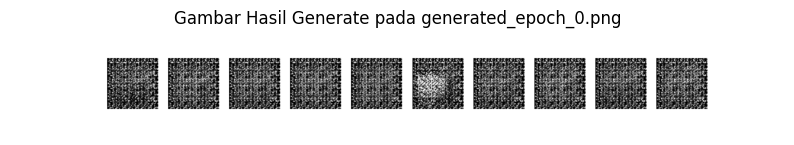


--- generated_epoch_25.png ---


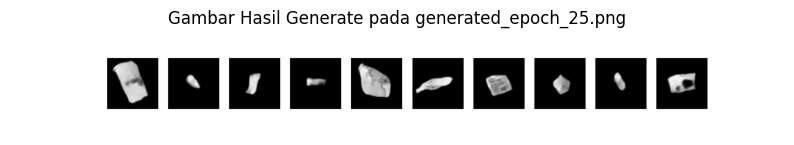


--- generated_epoch_49.png ---


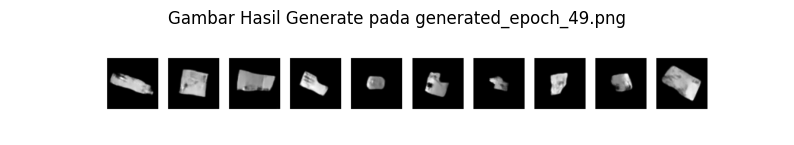

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re

def display_generated_images(directory='output/generated_images'):
    print(f"Menampilkan gambar dari direktori: {directory}")
    
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    def get_epoch_number(filename):
        match = re.search(r'generated_epoch_(\d+).png', filename)
        return int(match.group(1)) if match else 0

    image_files.sort(key=get_epoch_number)
    
    if len(image_files) > 2:
        display_files = [
            image_files[0],            
            image_files[len(image_files)//2],  
            image_files[-1]              
        ]
    elif len(image_files) > 0:
        display_files = image_files
    else:
        print("Tidak ada gambar yang ditemukan di direktori.")
        return

    for img_file in display_files:
        path = os.path.join(directory, img_file)
        print(f"\n--- {img_file} ---")
        
        img = mpimg.imread(path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis('off') 
        plt.title(f"Gambar Hasil Generate pada {img_file}")
        plt.show()

display_generated_images()
